<a href="https://colab.research.google.com/github/NiharikaGopinath/Summarization-and-Text-to-Speech/blob/main/MP_PegasusDemo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from transformers import PegasusForConditionalGeneration, AutoTokenizer
import torch


In [ ]:
% pip install sentencepiece

In [ ]:
!pip install transformers

In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:

model_name = 'google/pegasus-xsum'
torch_device = 'cuda' if torch.cuda.is_available() else 'cpu'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = PegasusForConditionalGeneration.from_pretrained(model_name).to(torch_device)


Downloading:   0%|          | 0.00/87.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.82M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.12G [00:00<?, ?B/s]

In [ ]:
text= """The time-scaling algorithm finds the time-optimal trajectory along a given path. What
if our real goal is to find the time-optimal trajectory between two states when we are
free to choose any collision-free path? Can we use the time-scaling algorithm in
conjunction with a collision-free path planner? Conceptually, imagine running the
time-scaling algorithm on all possible paths between the start and goal states. Then
the fastest of these is the global time-optimal trajectory.
Naturally, the problem is how to efficiently test a large number of possible paths.
One approach to this problem for robot manipulators was proposed by Shiller and
Dubowsky [383]. The approach is quite involved, and we only sketch it here. The first
step is to define a grid on the workspace and construct all collision-free paths (without
sharp turns) between the start and goal states moving along edges or diagonals of the
grid. The next step is to quickly compute rough lower-bound estimates of the traveling
times of these paths using a maximum velocity limit during the motion. The fastest
paths are selected and smoothed by using the grid points as control points for cubic
splines. The best of these paths is then submitted to the full time-scaling algorithm,
generating an upper bound on the optimal travel time. All paths with lower bounds
above this upper bound can be pruned. Of the remaining paths, the lower bounds
are more carefully calculated, and the process continues, using increasingly accurate
estimates of the lower bounds as the number of candidate paths is reduced. When the
pruning process has ended, only the best path in each path-neighborhood is considered
further. These best paths are submitted to a local optimization that may locally alter
the paths to allow them to be executed more quickly. This process uses the travel
times returned by the time-scaling algorithm as the objective function.
This approach combines collision-free path planning and time scaling in an iterative
fashion to arrive at a global near-time-optimal trajectory. In the next section,wediscuss
methods that do not separate the path-planning and time-scaling problems, but solve
directly in the state space.."""
stopWords = set (stopwords.words("english"))
words = word_tokenize(text)
freqTable = dict()
for word in words:
    word=word.lower()
    if word in stopWords:
        continue
    if word in freqTable:
        freqTable[word]+=1
    else:
        freqTable[word]=1
sentences=sent_tokenize(text)
sentenceValue = dict()
for sentence in sentences:
    for word,freq in freqTable.items():
        if word in sentence.lower():
            if sentence in sentenceValue:
                sentenceValue[sentence]+=freq
            else:
                sentenceValue[sentence]=freq
sumValues=0
for sentence in sentenceValue:
    sumValues+=sentenceValue[sentence]
    
avg=int(sumValues/len(sentenceValue))
summary=''
for sentence in sentences:
    if(sentence in sentenceValue) and (sentenceValue[sentence]>(1.2*avg)):
        summary+=" "+sentence
print(summary)

 Conceptually, imagine running the
time-scaling algorithm on all possible paths between the start and goal states. The first
step is to define a grid on the workspace and construct all collision-free paths (without
sharp turns) between the start and goal states moving along edges or diagonals of the
grid. The next step is to quickly compute rough lower-bound estimates of the traveling
times of these paths using a maximum velocity limit during the motion. The best of these paths is then submitted to the full time-scaling algorithm,
generating an upper bound on the optimal travel time. Of the remaining paths, the lower bounds
are more carefully calculated, and the process continues, using increasingly accurate
estimates of the lower bounds as the number of candidate paths is reduced.


In [ ]:
import re
from pprint import pprint

import numpy as np
from nltk import sent_tokenize, word_tokenize

from nltk.cluster.util import cosine_distance

MULTIPLE_WHITESPACE_PATTERN = re.compile(r"\s+", re.UNICODE)


def normalize_whitespace(text):
    """
    Translates multiple whitespace into single space character.
    If there is at least one new line character chunk is replaced
    by single LF (Unix new line) character.
    """
    return MULTIPLE_WHITESPACE_PATTERN.sub(_replace_whitespace, text)


def _replace_whitespace(match):
    text = match.group()

    if "\n" in text or "\r" in text:
        return "\n"
    else:
        return " "


def is_blank(string):
    """
    Returns `True` if string contains only white-space characters
    or is empty. Otherwise `False` is returned.
    """
    return not string or string.isspace()


def get_symmetric_matrix(matrix):
    """
    Get Symmetric matrix
    :param matrix:
    :return: matrix
    """
    return matrix + matrix.T - np.diag(matrix.diagonal())


def core_cosine_similarity(vector1, vector2):
    """
    measure cosine similarity between two vectors
    :param vector1:
    :param vector2:
    :return: 0 < cosine similarity value < 1
    """
    return 1 - cosine_distance(vector1, vector2)


'''
Note: This is not a summarization algorithm. This Algorithm pics top sentences irrespective of the order they appeared.
'''


class TextRank4Sentences():
    def __init__(self):
        self.damping = 0.85  # damping coefficient, usually is .85
        self.min_diff = 1e-5  # convergence threshold
        self.steps = 100  # iteration steps
        self.text_str = None
        self.sentences = None
        self.pr_vector = None

    def _sentence_similarity(self, sent1, sent2, stopwords=None):
        if stopwords is None:
            stopwords = []

        sent1 = [w.lower() for w in sent1]
        sent2 = [w.lower() for w in sent2]

        all_words = list(set(sent1 + sent2))

        vector1 = [0] * len(all_words)
        vector2 = [0] * len(all_words)

        # build the vector for the first sentence
        for w in sent1:
            if w in stopwords:
                continue
            vector1[all_words.index(w)] += 1

        # build the vector for the second sentence
        for w in sent2:
            if w in stopwords:
                continue
            vector2[all_words.index(w)] += 1

        return core_cosine_similarity(vector1, vector2)

    def _build_similarity_matrix(self, sentences, stopwords=None):
        # create an empty similarity matrix
        sm = np.zeros([len(sentences), len(sentences)])

        for idx1 in range(len(sentences)):
            for idx2 in range(len(sentences)):
                if idx1 == idx2:
                    continue

                sm[idx1][idx2] = self._sentence_similarity(sentences[idx1], sentences[idx2], stopwords=stopwords)

        # Get Symmeric matrix
        sm = get_symmetric_matrix(sm)

        # Normalize matrix by column
        norm = np.sum(sm, axis=0)
        sm_norm = np.divide(sm, norm, where=norm != 0)  # this is to ignore the 0 element in norm

        return sm_norm

    def _run_page_rank(self, similarity_matrix):

        pr_vector = np.array([1] * len(similarity_matrix))

        # Iteration
        previous_pr = 0
        for epoch in range(self.steps):
            pr_vector = (1 - self.damping) + self.damping * np.matmul(similarity_matrix, pr_vector)
            if abs(previous_pr - sum(pr_vector)) < self.min_diff:
                break
            else:
                previous_pr = sum(pr_vector)

        return pr_vector

    def _get_sentence(self, index):

        try:
            return self.sentences[index]
        except IndexError:
            return ""

    def get_top_sentences(self, number=5):

        top_sentences = {}

        if self.pr_vector is not None:

            sorted_pr = np.argsort(self.pr_vector)
            sorted_pr = list(sorted_pr)
            sorted_pr.reverse()

            index = 0
            for epoch in range(number):
                print (str(sorted_pr[index]) + " : " + str(self.pr_vector[sorted_pr[index]]))
                sent = self.sentences[sorted_pr[index]]
                sent = normalize_whitespace(sent)
                top_sentences[sent] = self.pr_vector[sorted_pr[index]]
                index += 1

        return top_sentences

    def analyze(self, text, stop_words=None):
        self.text_str = text
        self.sentences = sent_tokenize(self.text_str)

        tokenized_sentences = [word_tokenize(sent) for sent in self.sentences]

        similarity_matrix = self._build_similarity_matrix(tokenized_sentences, stop_words)

        self.pr_vector = self._run_page_rank(similarity_matrix)
        print(self.pr_vector)


text_str =  """
The time-scaling algorithm finds the time-optimal trajectory along a given path. What
if our real goal is to find the time-optimal trajectory between two states when we are
free to choose any collision-free path? Can we use the time-scaling algorithm in
conjunction with a collision-free path planner? Conceptually, imagine running the
time-scaling algorithm on all possible paths between the start and goal states. Then
the fastest of these is the global time-optimal trajectory.
Naturally, the problem is how to efficiently test a large number of possible paths.
One approach to this problem for robot manipulators was proposed by Shiller and
Dubowsky [383]. The approach is quite involved, and we only sketch it here. The first
step is to define a grid on the workspace and construct all collision-free paths (without
sharp turns) between the start and goal states moving along edges or diagonals of the
grid. The next step is to quickly compute rough lower-bound estimates of the traveling
times of these paths using a maximum velocity limit during the motion. The fastest
paths are selected and smoothed by using the grid points as control points for cubic
splines. The best of these paths is then submitted to the full time-scaling algorithm,
generating an upper bound on the optimal travel time. All paths with lower bounds
above this upper bound can be pruned. Of the remaining paths, the lower bounds
are more carefully calculated, and the process continues, using increasingly accurate
estimates of the lower bounds as the number of candidate paths is reduced. When the
pruning process has ended, only the best path in each path-neighborhood is considered
further. These best paths are submitted to a local optimization that may locally alter
the paths to allow them to be executed more quickly. This process uses the travel
times returned by the time-scaling algorithm as the objective function.
This approach combines collision-free path planning and time scaling in an iterative
fashion to arrive at a global near-time-optimal trajectory. In the next section,wediscuss
methods that do not separate the path-planning and time-scaling problems, but solve
directly in the state space.."""

tr4sh = TextRank4Sentences()
tr4sh.analyze(text_str)
summary=tr4sh.get_top_sentences(3)
print(summary)
s=""
for i in summary:
  for j in i:
    for k in j:
      if k==" ":
        print(" ",end="")
        s+=" "
      elif k!='\n' and not k.isdigit():
        print(k,end="")
        s+=k
      elif k=="\n":
        print()
        s+='\n'
  print(" ",end="")
print(s)        



[1.18497067 0.77474396 0.7980722  1.1760328  1.20376464 1.05688324
 0.5367893  0.93703666 1.25808719 1.18896373 0.98253235 1.34406446
 0.53746299 1.28122532 1.05333724 0.86724095 1.16522781 0.68048431
 0.97308017]
11 : 1.3440644634728756
13 : 1.2812253233647501
8 : 1.2580871914110983
{'The best of these paths is then submitted to the full time-scaling algorithm,\ngenerating an upper bound on the optimal travel time.': 1.3440644634728756, 'Of the remaining paths, the lower bounds\nare more carefully calculated, and the process continues, using increasingly accurate\nestimates of the lower bounds as the number of candidate paths is reduced.': 1.2812253233647501, 'The first\nstep is to define a grid on the workspace and construct all collision-free paths (without\nsharp turns) between the start and goal states moving along edges or diagonals of the\ngrid.': 1.2580871914110983}
The best of these paths is then submitted to the full time-scaling algorithm,
generating an upper bound on the op

In [ ]:
src_text = [summary]


batch = tokenizer.prepare_seq2seq_batch(src_text, truncation=True, padding='longest',return_tensors='pt').to(torch_device)
translated = model.generate(**batch)
tgt_text = tokenizer.batch_decode(translated, skip_special_tokens=True)
print(tgt_text)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:3402: FutureWarning: 
`prepare_seq2seq_batch` is deprecated and will be removed in version 5 of HuggingFace Transformers. Use the regular
`__call__` method to prepare your inputs and the tokenizer under the `as_target_tokenizer` context manager to prepare
your targets.

Here is a short example:

model_inputs = tokenizer(src_texts, ...)
with tokenizer.as_target_tokenizer():
    labels = tokenizer(tgt_texts, ...)
model_inputs["labels"] = labels["input_ids"]

See the documentation of your specific tokenizer for more details on the specific arguments to the tokenizer of choice.
For a more complete example, see the implementation of `prepare_seq2seq_batch`.

  warnings.warn(formatted_warning, FutureWarning)


['We have developed a time-scaling algorithm for constructing collision-free paths between start and goal states on a workspace.']


In [ ]:
src_text = [summary]


batch = tokenizer.prepare_seq2seq_batch(src_text, truncation=True, padding='longest',return_tensors='pt').to(torch_device)
translated = model.generate(**batch)
tgt_text = tokenizer.batch_decode(translated, skip_special_tokens=True)
print(tgt_text)



/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:3402: FutureWarning: 
`prepare_seq2seq_batch` is deprecated and will be removed in version 5 of HuggingFace Transformers. Use the regular
`__call__` method to prepare your inputs and the tokenizer under the `as_target_tokenizer` context manager to prepare
your targets.

Here is a short example:

model_inputs = tokenizer(src_texts, ...)
with tokenizer.as_target_tokenizer():
    labels = tokenizer(tgt_texts, ...)
model_inputs["labels"] = labels["input_ids"]

See the documentation of your specific tokenizer for more details on the specific arguments to the tokenizer of choice.
For a more complete example, see the implementation of `prepare_seq2seq_batch`.

  warnings.warn(formatted_warning, FutureWarning)


['We have developed a time-scaling algorithm for constructing collision-free paths between start and goal states on a workspace.']


In [ ]:
l=tgt_text[0].split()
for i in range(len(l)):
  if i%5==0:
    print()
  print(l[i],end=" ")



We have developed a time-scaling 
algorithm for constructing collision-free paths 
between start and goal states 
on a workspace. 

In [ ]:
from gtts import gTTS 
import os

language = 'en'
speech = gTTS(text = str(tgt_text), lang = language, slow = False)
speech.save("audio.mp3")
os.system("start audio.mp3")

32512

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


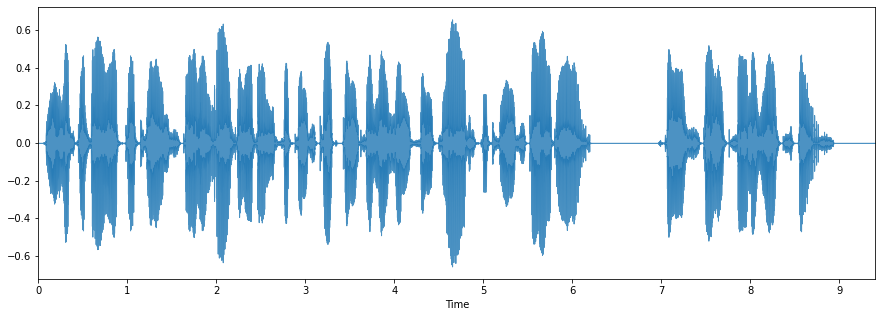

In [ ]:
%matplotlib inline
import numpy, scipy, matplotlib.pyplot as plt, IPython.display as ipd
import librosa, librosa.display
x, sr = librosa.load('/content/audio.mp3')
ipd.Audio(x, rate=sr)
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))
librosa.display.waveplot(x, sr, alpha=0.8)

In [ ]:
pip install gTTS

In [ ]:
model_name = 'google/pegasus-large'
torch_device = 'cuda' if torch.cuda.is_available() else 'cpu'
tokenizer = PegasusTokenizer.from_pretrained(model_name)
model = PegasusForConditionalGeneration.from_pretrained(model_name).to(torch_device)

In [ ]:
src_text = [
    """throwaway here for obvious reasons.. today my friends and i decided to go off-roading in nowhereland. we packed up all our stuff, made the roughly
hour drive off to the mountains to make a fire, go fishing and just talk about life until we got too tired to stay any longer. we got everything packed
up and brought along one of my friends’ dog because she’s awesome and loves the outdoors. the dog was flipping out in the suv on the way to the
path because she knew was a kick-ass day she was about to have breaking out of her normally lame, domesticated dog life. my friends decided to
drink during the off-roading adventure, which was fine because i volunteered to drive since i cannot drink alcohol (mouth is wired shut [long story
but i can’t drink alcohol for a while]) so we were playing it safe. the dog couldn’t be any happier and was about to jump out of the truck (literally)
when we got there so the dog’s owner let her get out and run along side of us while we drove the dirt road up to the destination for the fire. as i was
driving, the dog went in and out of vision, mostly biting the tires as most dogs do, playing around. the owner kept asking us (the two guys up front)
if we could see her. we said yes, and kept driving. as i was driving at no more than 5-10mph along the dirt road, i could hear the dog biting at the
tires playfully, but we just laughed it off bc we thought she was having fun. the horrible, seconds-long event that ensued was me feeling the dreaded
’double-thud’ under the tires and heard the dog yelp in pain. i instantly stopped the ... ."""
]


batch = tokenizer.prepare_seq2seq_batch(src_text, truncation=True, padding='longest').to(torch_device)
translated = model.generate(**batch)
tgt_text = tokenizer.batch_decode(translated, skip_special_tokens=True)
print(tgt_text)

['the dog couldn’t be any happier and was about to jump out of the truck (literally) when we got there so the dog’s owner let her get out and run along side of us while we drove the dirt road up to the destination for the fire. as i was driving at no more than 5-10mph along the dirt road, i could hear the dog biting at the tires playfully, but we just laughed it off bc we thought she was having fun.']


In [ ]:
src_text = [
    """this happened 5/6 years ago so my whole family every xmas day goes around to my aunties for celebrations. my cousin (of course) was there and he
asked if i wanted to play cops and robbers. i accepted of course. now, next to the side of my aunts house is a little area with a small fence, a covered
water tank and super duper sharp stones. my cousin (who was the cop) was gaining on me. i (tried) to jump over the fence, aaand i failed the jump
and went crashing onto the gravel, my leg hitting the sharpest bit and, then the next thing i knew it had a nasty gash."""
]


batch = tokenizer.prepare_seq2seq_batch(src_text, truncation=True, padding='longest').to(torch_device)
translated = model.generate(**batch)
tgt_text = tokenizer.batch_decode(translated, skip_special_tokens=True)
print(tgt_text)

['now, next to the side of my aunts house is a little area with a small fence, a covered water tank and super duper sharp stones.']


In [ ]:
model_name = 'google/pegasus-reddit_tifu'
torch_device = 'cuda' if torch.cuda.is_available() else 'cpu'
tokenizer = PegasusTokenizer.from_pretrained(model_name)
model = PegasusForConditionalGeneration.from_pretrained(model_name).to(torch_device)

In [ ]:
src_text = [
    """this happened 5/6 years ago so my whole family every xmas day goes around to my aunties for celebrations. my cousin (of course) was there and he
asked if i wanted to play cops and robbers. i accepted of course. now, next to the side of my aunts house is a little area with a small fence, a covered
water tank and super duper sharp stones. my cousin (who was the cop) was gaining on me. i (tried) to jump over the fence, aaand i failed the jump
and went crashing onto the gravel, my leg hitting the sharpest bit and, then the next thing i knew it had a nasty gash."""
]


batch = tokenizer.prepare_seq2seq_batch(src_text, truncation=True, padding='longest').to(torch_device)
translated = model.generate(**batch)
tgt_text = tokenizer.batch_decode(translated, skip_special_tokens=True)
print(tgt_text)

["played cops and robbers, tried to jump over a fence, ended up with a nasty gash on my leg. i'm not a good cop."]


In [ ]:
src_text = [
    """throwaway here for obvious reasons.. today my friends and i decided to go off-roading in nowhereland. we packed up all our stuff, made the roughly
hour drive off to the mountains to make a fire, go fishing and just talk about life until we got too tired to stay any longer. we got everything packed
up and brought along one of my friends’ dog because she’s awesome and loves the outdoors. the dog was flipping out in the suv on the way to the
path because she knew was a kick-ass day she was about to have breaking out of her normally lame, domesticated dog life. my friends decided to
drink during the off-roading adventure, which was fine because i volunteered to drive since i cannot drink alcohol (mouth is wired shut [long story
but i can’t drink alcohol for a while]) so we were playing it safe. the dog couldn’t be any happier and was about to jump out of the truck (literally)
when we got there so the dog’s owner let her get out and run along side of us while we drove the dirt road up to the destination for the fire. as i was
driving, the dog went in and out of vision, mostly biting the tires as most dogs do, playing around. the owner kept asking us (the two guys up front)
if we could see her. we said yes, and kept driving. as i was driving at no more than 5-10mph along the dirt road, i could hear the dog biting at the
tires playfully, but we just laughed it off bc we thought she was having fun. the horrible, seconds-long event that ensued was me feeling the dreaded
’double-thud’ under the tires and heard the dog yelp in pain. i instantly stopped the ... ."""
]


batch = tokenizer.prepare_seq2seq_batch(src_text, truncation=True, padding='longest').to(torch_device)
translated = model.generate(**batch)
tgt_text = tokenizer.batch_decode(translated, skip_special_tokens=True)
print(tgt_text)

['went off-roading with friends and brought a friend’s dog along. the dog went in and out of vision, biting the tires, and i felt the dreaded ’double-thud’ under the tires and heard the dog yelp in pain.']
